# <i>Individual household electric power consumption</i><br>Data analysis project

Data source: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

## Introduction

Objective of the project is to analyze given data set and propose business case of
using machine learning or statistical analysis to bring some value.

## The data

Given data set contains measurements of electric power consumption in one
household with one minute sampling rate over a period of 4 years. Measurement
includes date, time, global active and reactive power, voltage, current (named global
intensity) and electricity usage from 3 sub areas – kitchen, laundry room and water-
heater with air conditioner.

## Loading the data

First step of the analysis is to import data, check missing records ratio and prepare for further analysis

### packages import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rc('axes', axisbelow=True)

### checking data format

In [2]:
with open(r'./household_power_consumption.txt', 'r') as file:
    head = [next(file) for _ in range(5)]    
head

['Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3\n',
 '16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000\n',
 '16/12/2006;17:25:00;5.360;0.436;233.630;23.000;0.000;1.000;16.000\n',
 '16/12/2006;17:26:00;5.374;0.498;233.290;23.000;0.000;2.000;17.000\n',
 '16/12/2006;17:27:00;5.388;0.502;233.740;23.000;0.000;1.000;17.000\n']

### checking number of lines

In [3]:
sum(1 for line in open('./household_power_consumption.txt', 'r'))

2075260

Data is provided as single CSV file. Reading first lines of the file showed 9 columns with semicolon (;) used as separator and 2,075,259 data rows. First two columns are Date and Time in formats ‘dd/mm/yyyy’ and ‘hh:mm:ss’.

### checking how missing values are filled
#### as stated in description - a lot missing records for 28/4/2007

In [4]:
data = pd.read_csv(r'./household_power_consumption.txt', sep=';', low_memory=False)
data[data['Date'] == '28/4/2007'].sample(5)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
191834,28/4/2007,22:38:00,?,?,?,?,?,?,NaN
191423,28/4/2007,15:47:00,?,?,?,?,?,?,NaN
191025,28/4/2007,09:09:00,?,?,?,?,?,?,NaN
191649,28/4/2007,19:33:00,?,?,?,?,?,?,NaN
191009,28/4/2007,08:53:00,?,?,?,?,?,?,NaN


Missing values are represented as question mark (?) between semicolons or missing for last column (what was differently than described by data provider).

### reading the file, date parsing, replacing missing values

as checked above, separator is semicolon (;), <br>missing values are represented by (?) or empty field, <br>timestamp is devided into two columns - date and time with format {dd/m/yyyy} {hh:mm:ss}

In [5]:
data = pd.read_csv(r'./household_power_consumption.txt', sep=';', na_values='?', 
                   parse_dates=[[0,1]], infer_datetime_format=True, index_col='Date_Time')

#### shape of the dataframe

In [6]:
data.shape

(2075259, 7)

#### sample of the data

In [7]:
data.sample(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2008-02-22 11:22:00,0.510,0.126,238.80,2.4,0.0,0.0,0.0
2008-05-04 01:42:00,0.260,0.000,241.36,1.0,0.0,0.0,1.0
2008-11-28 12:19:00,1.400,0.078,243.21,5.6,0.0,0.0,18.0
2009-12-05 18:05:00,2.810,0.494,236.66,12.4,0.0,0.0,0.0
2009-05-16 07:37:00,1.132,0.000,238.98,5.4,0.0,0.0,1.0


#### count how many of empty records we have

In [8]:
data.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

#### check if missing are whole rows or single values

In [9]:
data.isnull().any(axis=1).sum()

25979

In [10]:
print("That is {0:.3%} of all records".format((data.isnull().any(axis=1).sum() / data.count())[0]))

That is 1.268% of all records


Missing records occurs as whole rows – there was no single missing value.

#### check if dates are evenly

In [11]:
# calc differences between consecutive dates
(data.index.shift(n=1, freq='1min') - data.index).value_counts()

00:01:00    2075259
Name: Date_Time, dtype: int64

it means that our timepoints are distributed with equal intervals = 1min

#### check the longest period of consecutive missing values

In [12]:
# we can focus on one column
na = data.Voltage.isnull().astype(int)
notna = data.Voltage.notnull().astype(int)

# take groups of not null cumulative sum (this value is not chanings for consecutive NA values)
# for each group count number of NA values
# then take max 
longest_na = na.groupby(notna.cumsum()).sum().max()
print("Longest period of consecutive missing values was {} minutes = {:.2f} days".format(longest_na, longest_na/60/24))

Longest period of consecutive missing values was 7226 minutes = 5.02 days


All date-time points were presented with equal interval – 1 minute. There was 25’979 missing time points, which is 1.268% of total data. The longest consecutive period of missing values lasted 7226 minutes which is 5.02 days.

## Visualization

Next step is to check data characteristic and visualize of the data

### check basics statistic

In [13]:
pd.options.display.float_format = '{:20,.3f}'.format
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,"2,049,280.000","2,049,280.000","2,049,280.000","2,049,280.000","2,049,280.000","2,049,280.000","2,049,280.000"
mean,1.092,0.124,240.840,4.628,1.122,1.299,6.458
std,1.057,0.113,3.240,4.444,6.153,5.822,8.437
min,0.076,0.000,223.200,0.200,0.000,0.000,0.000
25%,0.308,0.048,238.990,1.400,0.000,0.000,0.000
50%,0.602,0.100,241.010,2.600,0.000,0.000,1.000
75%,1.528,0.194,242.890,6.400,0.000,1.000,17.000
max,11.122,1.390,254.150,48.400,88.000,80.000,31.000


### distribution of the data

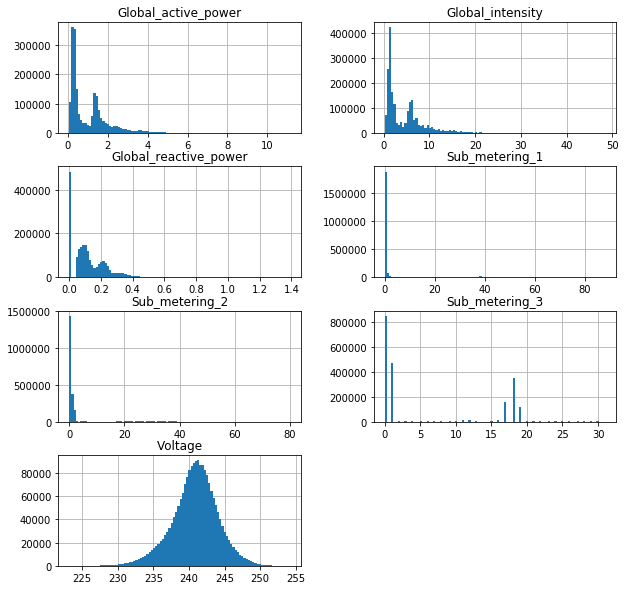

In [14]:
data.hist(layout=(4,2), figsize=(10,10), sharex=False, bins=100)
plt.show()

As we can see in the statistics and histograms, distributions of global active and reactive power, global intensity and sub metering areas are all skewed maximum near to zero. All of them are bi-modal distributed (especially you can see it on global active power). Voltage distribution is close to Gaussian.

### correlations

Because active power is calculated as product of voltage and current (assuming phase shift close to zero) and fact that voltage in energy network should be constant, we can expect very high correlation between global_active_power and Global_intensity. In reality voltage changes – mainly during period of high energy consumption. However, voltage changes in our data are relatively small (std ~1.5%).
<br><br>
We can expect high correlation between Global_active_power and Global_intensity and mediate negative correlation between Global_intensity and Voltage. Global_intensity should also have some small positive correlation to subs-metering energy consumption. 

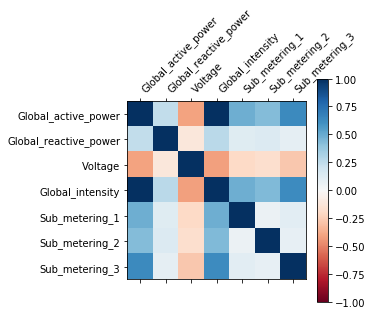

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000,0.247,-0.400,0.999,0.484,0.435,0.639
Global_reactive_power,0.247,1.000,-0.112,0.266,0.123,0.139,0.090
Voltage,-0.400,-0.112,1.000,-0.411,-0.196,-0.167,-0.268
Global_intensity,0.999,0.266,-0.411,1.000,0.489,0.440,0.627
Sub_metering_1,0.484,0.123,-0.196,0.489,1.000,0.055,0.103
Sub_metering_2,0.435,0.139,-0.167,0.440,0.055,1.000,0.081
Sub_metering_3,0.639,0.090,-0.268,0.627,0.103,0.081,1.000


In [15]:
a=plt.matshow(data.corr(), vmax=1, vmin=-1, cmap='RdBu')
a.axes.set_xticklabels([' '] + list(data.columns), rotation=45, horizontalalignment='left')
a.axes.set_yticklabels([' '] + list(data.columns))
plt.colorbar()
plt.grid(False)
plt.show()
data.corr()

As we expected – Global_active_power and Global_intensity has correlation around 1, Global_intensity and Voltage as negative correlation (-0.41) and some small positive between Global_intensity and subs-metering (0.44-0.63).

### Voltage as function of current

To check how Voltage depends on Global_intensity, there was scatter plot prepared, showing on x-axis intensity and on y-axis voltage for all timestamps

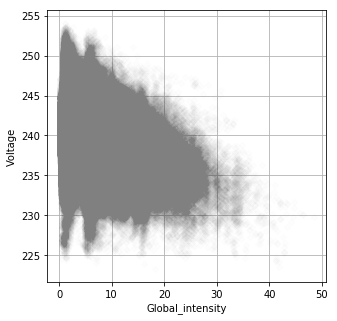

In [16]:
data.plot.scatter(figsize=(5,5), x='Global_intensity', y='Voltage', marker='D', alpha=0.01, color='grey')
plt.show()

We can observe, that higher current (Global_intensity) corresponds to voltage drops. However, for smaller values of global_intensity we get wide range of voltage changes. This observation can be explained by the fact that measured voltage is impacted by two factors: household intensity and energy network intensity. The latter quantity is not measured, but we can observe effect of their increases as voltage drops.

### checking data periodicity

Let us back to histograms from "distribution of the data" paragraph and what we could also see on figure in section "Voltage as function of curren" - bi-modal distribution of Global_intensity. Such shape of power consumption can indicate that usage changes periodically. To check that hypothesis, there were prepared 3 sets from the data – monthly, daily and hourly. For each set, data has been grouped by intervals as name suggests (by months, week days and hours) and calculated average power consumption for each group.

In [17]:
# adding sub_metering_4 as the remaining part of power usage
data['Sub_metering_others'] = data.Global_active_power*1000/60 - data.Sub_metering_1 - data.Sub_metering_2 - data.Sub_metering_3

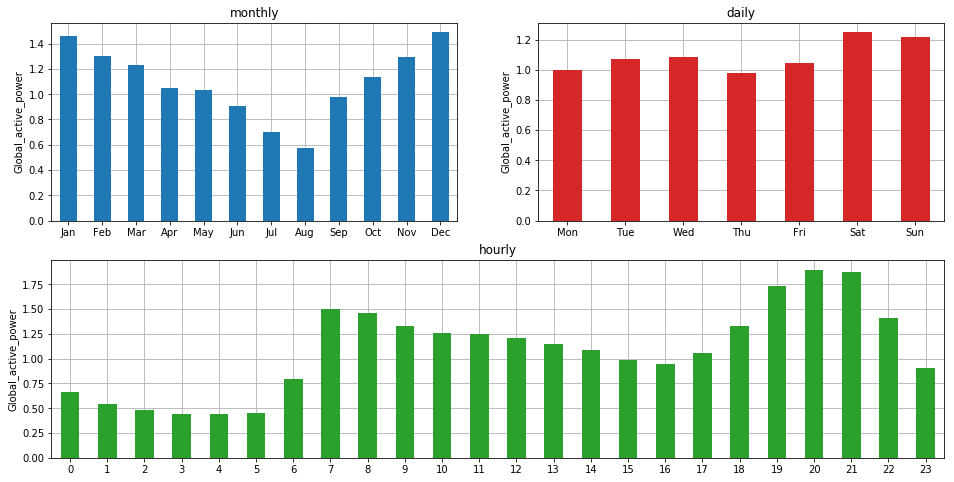

In [18]:
# grouping by 'month_name'/'weekday_name' change order of months / week days :P
# that is why I decided to overriden index manually

monthly = data.groupby(data.index.month).mean()
monthly.index = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

daily = data.groupby(data.index.dayofweek).mean()
daily.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

hourly = data.groupby(data.index.hour).mean()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
monthly.Global_active_power.plot.bar(ax=axs[0,0], rot=0, title='monthly', color='#1f77b4')
daily.Global_active_power.plot.bar(ax=axs[0,1], rot=0, title='daily', color='#d62728')
hourly.Global_active_power.plot.bar(ax=plt.subplot(212), rot=0, title='hourly', color='#2ca02c')
axs[0,0].axes.set_ylabel("Global_active_power")
axs[0,1].axes.set_ylabel("Global_active_power")
plt.ylabel("Global_active_power")
plt.xlabel('')
plt.show()

In [19]:
print('Monthly global intensity Dec to Aug: {0:.0%}'.format((monthly.loc['Dec'] / monthly.loc['Aug']).Global_intensity))
print('Daily global intensity during weekends to work days: {0:.0%}'.format((daily.loc['Sat':'Sun'].mean() / daily.loc['Mon':'Fri'].mean()).Global_intensity))

Monthly global intensity Dec to Aug: 248%
Daily global intensity during weekends to work days: 119%


We can observe changes in each set. For monthly basis the larger consumption is for winter months (Nov-Mar), and lowest for summer (May-Sep). Relative difference between August and December is ~250%. For week days changes are smaller, but visible. Power consumption increase 20% for weekends. Hourly consumption profile is the lowest for night (0-6 a.m.) and has two peaks at 7 am. and 8 pm which correspond to morning wake up and returns from work.

Now let us check each changes for each sub_metering area. As data provider said, sub_metering_1 correspond to kitchen (dishwasher, oven, microwave), sub_metering_2 to laundry room (washing-machine, a tumble-drier, a refrigerator) and sub_metering_3 to electric water-heater and an air-conditioner. Also, there is suggestion to calculate power consumption per minute not measured in any of sub_metering areas. Plot are presented below:

#### monthly

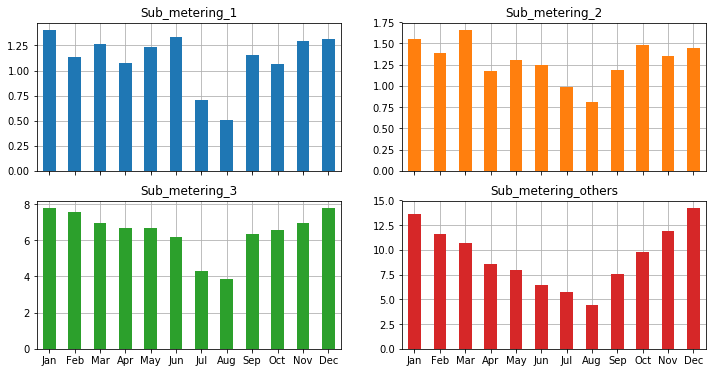

In [20]:
monthly[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_others']].plot.bar(
    subplots=True, layout=(2,2), rot=0, figsize=(12,6), legend=False)
plt.xlabel('')
plt.show()

The changes can be seen mostly clear for sub_metering_others and sub_metering_3. The first can suggest that household members spend more time (and electricity) in house for winter when the weather does not encourage spending time outside. The latter shows that water heater during winter uses two time more energy than in summer.

#### daily

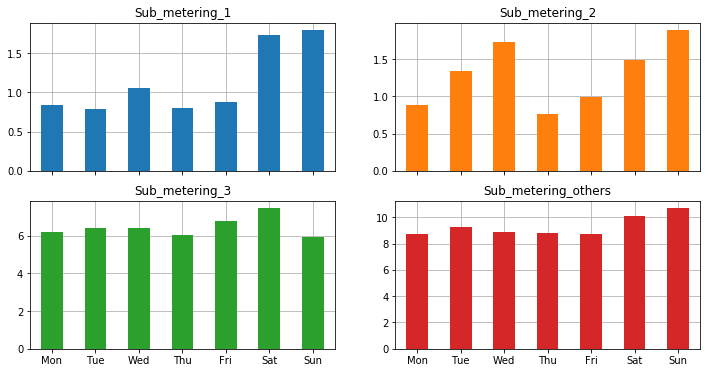

In [21]:
daily[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_others']].plot.bar(
    subplots=True, layout=(2,2), rot=0, figsize=(12,6), legend=False, sharex=True)
plt.xlabel('')
plt.show()

On a daily basis we can observe much higher energy consumption in kitchen for weekends, and two peaks in laundry. Base on that, we can assume something about household members habits – during working days they eat out, but on weekends they cook themselves and do laundry two time a week mainly Wednesdays and Sundays. Changes for water heater/air condition are small. In the others areas energy usage is a bit more higher during weekends (spending more time in house).

#### hourly

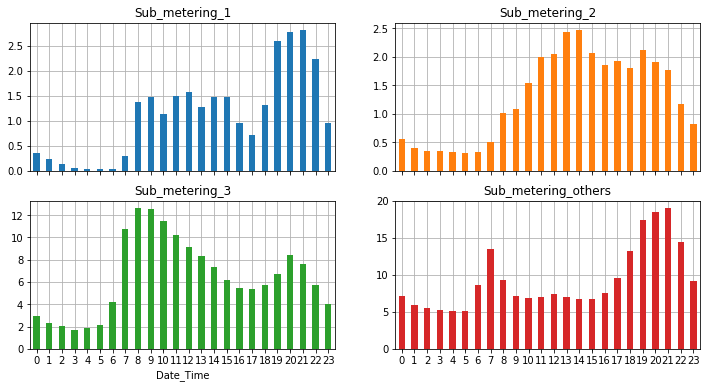

In [22]:
hourly[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_others']].plot.bar(
    subplots=True, layout=(2,2), figsize=(12,6), rot=0, legend=False, sharex=True)
plt.xlabel('')
plt.show()

On hourly plots we can observe drop usage during the night when all household members are sleeping. Around 7-8 am we can observe increase in usage, mainly in the kitchen, water heat (because of morning shower) and other areas. The second peak occurs on evenings (7-10 pm) showing household activities. Profile for laundry is different from other, having peak around midday.

### correlations for monthly, daily and hourly sets

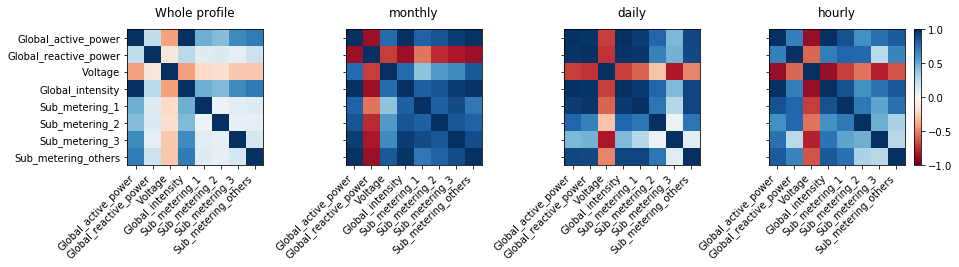

In [23]:
corrs = [data.corr(), monthly.corr(), daily.corr(), hourly.corr()]
corrs_name = ['Whole profile', 'monthly', 'daily', 'hourly']

fig, axs = plt.subplots(1, len(corrs), figsize=(15, 2.5))

for i in range(len(corrs)):
    im = axs[i].matshow(corrs[i], vmax=1, vmin=-1, cmap='RdBu')
    
    axs[i].set_title(corrs_name[i])
    axs[i].grid(False)
    
    axs[i].tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    axs[i].axes.set_xticklabels([' '] + list(data.columns), rotation=45, horizontalalignment='right')
    axs[i].axes.set_yticklabels([])

axs[0].axes.set_yticklabels([' '] + list(data.columns))
plt.colorbar(im, ax=axs[-1])

plt.show()

### <br><br><br><i>Based on the data provided, we can attempt to predict electricity demands for households.</i>

## Multiplicative seasonality

The first proposed method of predicting electricity usage is multiplicative seasonality. This method assume that our data has some general trend (linear) with proportional seasonality effect – it means that increase of energy consumption in winter months to summer is the same proportion each year, rather than assuming that absolute difference is constant each year.

As it was shown before, our data has 3 seasonal changes – monthly, daily and hourly. Predicted value will be hourly electricity consumption in watt-hour, calculated as sum of Global_active_power * 1000 / 60 resampled in hour basis. Knowing now that our data has a seasonality, correct way of filling missing values seems to copy measure from the same time the week before. Data has been split into test and train sets, respectively as last week of measures and the rest.

#### prepare the data

In [24]:
# fill mising values - copy values from the same time week before
while any(data.Global_active_power.isna()):
    data = data.fillna(data.shift(7*24*60))
    data = data.fillna(data.shift(-7*24*60))

# calculate hourly usage in Watthour
data['y'] = data.Global_active_power*1000/60
data = data[['y']].resample('h').sum()

# split into train and test 
train = data.iloc[:-168].copy()
test = data.iloc[-168:].copy()

#### define fitting and calculating functions

In [25]:
import numpy.polynomial.polynomial as poly
import matplotlib.dates as mdates

def fit(df):
    df = df.copy()
    df['x'] = mdates.date2num(df.index)

    c_0 = poly.polyfit(df.x, df.y, 1)
    df['linfit'] = poly.polyval(df.x, c_0)

    c_m = df.groupby(df.index.month).apply(lambda d: d.y.mean()/d.linfit.mean())
    c_d = df.groupby(df.index.dayofweek).apply(lambda d: d.y.mean()/d.linfit.mean())
    c_h = df.groupby(df.index.hour).apply(lambda d: d.y.mean()/d.linfit.mean())

    return c_0, c_m, c_d, c_h

def calc_values(df, c_0, c_m, c_d, c_h):
        
    df = df.copy()
    df['y1'] = poly.polyval(mdates.date2num(df.index), c_0)
    return df.apply(lambda d: d.y1*c_m[d.name.month]*c_d[d.name.dayofweek]*c_h[d.name.hour], axis=1)

Firstly linear trend will be computed (c_0). Then, the data will be grouped by months, for each group will calculate: mean usage and proportion to linear trend. That process will give us coefficients for each month (c_m). This step will be repeated for week days and hours (c_d, c_h).

#### fit and predict

In [26]:
# find coefficients
c_0, c_m, c_d, c_h = fit(train)

# calcute fitted values
test['y_prediction'] = calc_values(test, c_0, c_m, c_d, c_h)

In [27]:
# print("c_0", c_0)
# print("c_m", c_m.T)
# print("c_d", c_d.T)
# print("c_h", c_h.T)

Trend line was multiplied by calculated coefficients related to date. Predicted values (in test set – last week) compared to measured and assessment of the prediction quality are presented below.

#### Multiplicative seasonality - predicted electricity usage for last week of measures

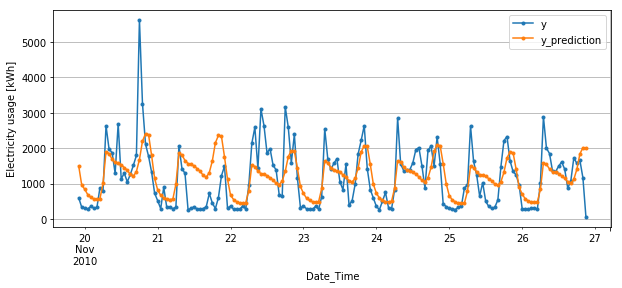

In [28]:
test[['y', 'y_prediction']].plot(figsize=(10,4), marker='.')
plt.ylabel('Electricity usage [kWh]')
plt.show()

#### Assessment of multiplicative seasonality prediction quality

In [29]:
def check_quality(target, prediction):
    
    return pd.DataFrame([
            ['Mean absolute error', "{0:.2f}".format(abs(prediction - target).mean())],
            ['Root mean squared error', "{0:.2f}".format(np.sqrt(np.mean((prediction - target)**2)))],
            ['Relative absolute error', "{0:.2%}".format(abs(prediction - target).sum() / abs(target.mean() - target).sum())],
            ['Root relative squared error', "{0:.2%}".format(((prediction - target)**2).sum() / ((target.mean() - target)**2).sum())],
            ['Correlation', "{0:.3f}".format(pd.concat([target, prediction], axis=1).corr('pearson').loc[target.name, prediction.name])]
        ], columns=['Measure', prediction.name])

check_quality(test.y, test.y_prediction)

,Measure,y_prediction
0,Mean absolute error,498.96
1,Root mean squared error,691.52
2,Relative absolute error,72.26%
3,Root relative squared error,65.68%
4,Correlation,0.592


## Autoregression model

As the next proposed forecasting method proposed is autoregression model from Statsmodels library.

Autoregressive model assume that output value depends linearly on previous values of time series and stochastic term. As we already know, our data is stochastic, but with clear seasonal components, so this model will be presented only as a reference for next model.

Prediction of this model has been prepared as previously: replacing missing values in data set with values for the same time last week, predicted value - electricity consumption in watt-hour sampled on hourly basis for the last week of measures.

#### prepare the data, fit AR model and present predicted electricity usage for last week of measures

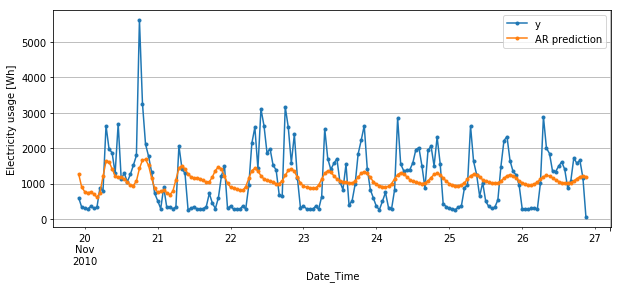

In [30]:
from statsmodels.tsa.ar_model import AR

train = data.iloc[:-168].copy()
test = data.iloc[-168:].copy()

AR_model = AR(train.y)
AR_fit = AR_model.fit()
test['AR prediction'] = AR_fit.predict(start=test.index[0], end=test.index[-1])

test[['y', 'AR prediction']].plot(figsize=(10,4), marker='.')
plt.ylabel('Electricity usage [Wh]')
plt.show()

Results from AR model are presented above. As it was expected, prediction is not accurate, but for the first day it reflect hourly changes of electricity usage. Then results are less accurate, closer to mean value, but still oscillates with daily changes frequency. This fact was reflected by quite high correlation to measures – this and other quality
check are listed below

#### Assessment of AR model prediction quality

In [31]:
check_quality(test.y, test['AR prediction'])

,Measure,AR prediction
0,Mean absolute error,580.69
1,Root mean squared error,749.00
2,Relative absolute error,84.10%
3,Root relative squared error,77.05%
4,Correlation,0.617


## Seasonal Autoregressive Integrated Moving-Average model

As the next proposed forecasting method proposed is seasonal autoregressive integrated moving-average model from Statsmodels library.

Seasonal Autoregressive Integrated Moving-Average models the next step in the sequence as a linear function of the differenced observations, errors, differenced seasonal observations, and seasonal errors at prior time steps. It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level.

Notation of this model is “SARIMA(p, d, q)(P, D, Q)m” and as we can see it requires 7 input parameters, all are non-
negative integers. First 3 – p, d and q correspond respectively to the order (number of time lags) of the autoregressive model; the degree of differencing (the number of times the data have had past values subtracted), the order of the moving-average model. Next 3 – uppercase letters P, D and Q refers to the same quantities as lowercase equivalents for seasonal part. The last – m is refers to number of periods in each season. Choosing parameters is not straightforward procedure, often base on checking different sets of them and comparing the results.

In our case, m was set as 24 (describing changes during a day). The rest of parameters was chosen arbitrary, dictated mainly by the computing power: p=0, d=0, q=1, P=0, D=1, Q=1.

#### fit SARIMA model (using data prepared before) and present predicted electricity usage for last week of measures

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


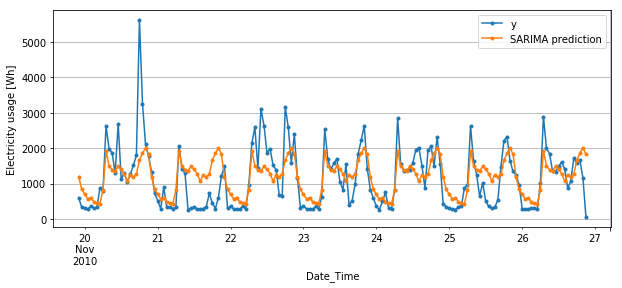

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_model = SARIMAX(train.y, order=(0, 0, 1), seasonal_order=(0, 1, 1, 24))
SARIMA_fit = SARIMA_model.fit(disp=False)
test['SARIMA prediction'] = SARIMA_fit.predict(start=test.index[0], end=test.index[-1])
    
test[['y', 'SARIMA prediction']].plot(figsize=(10,4), marker='.')
plt.ylabel('Electricity usage [Wh]')
plt.show()

Results of the prediction has been presented on figure ablove. Assessment of prediction quality is listed below

#### Assessment of SARIMA model prediction quality

In [33]:
check_quality(test.y, test['SARIMA prediction'])

,Measure,SARIMA prediction
0,Mean absolute error,445.84
1,Root mean squared error,636.44
2,Relative absolute error,64.57%
3,Root relative squared error,55.63%
4,Correlation,0.679


## Machine-Learning method – LSTM neural network

The last presented method is machine learning, precisely recurrent neural network. It uses Long Short-Term Memory, which is suitable for time series predictions. Using neural networks for big data set is more efficient in terms of results accuracy compared to required computational power.

Keras library was used for the analysis. The data has been processed and divided as previously – electricity consumption in watt-hour on hour basis, testing set as last week of measures, training set as the rest. As input for the network. Input for the model includes:<br>
• previous 24 measures for consumption<br>
• month of prediction date<br>
• week day of prediction date<br>
• hour of prediction time

#### packages import

In [34]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using TensorFlow backend.


### prepare the data

#### create a copy of dataset, add month, day and hour numbers

In [35]:
# prepare copy of our dataset
data_ml = data.copy()

# add month, day and hour to dataframe
data_ml['m'] = data_ml.index.month
data_ml['d'] = data_ml.index.dayofweek
data_ml['h'] = data_ml.index.hour

#### add to each row data about previous usage

In [36]:
def format_input(data, backward_seq=24):
    
    # add new columns
    new_cols = ['v(t-{})'.format(i) for i in range(backward_seq, 0, -1)][::-1]
    n_c = data.shape[1] # new columns index
    df = data.reindex(columns=[*data.columns.tolist(), *new_cols])
    
    # for rows < backward sequence fill only avaiable measures
    for idx in range(1, backward_seq):
        df.iloc[idx, n_c:n_c+idx] = data.y.iloc[:idx].values[::-1]
    
    # for the rest of rows fill new columns with 'backward_seq' previous measures
    for idx in range(backward_seq, len(data)):
        df.iloc[idx, n_c:] = data.y.iloc[idx-backward_seq:idx].values[::-1]
        
    return df

data_ml = format_input(data_ml).fillna(data_ml.y.mean())

#### data normalization

In [37]:
n_mean = data_ml.mean()
n_deno = data_ml.max() - data_ml.min()
data_ml = (data_ml - n_mean) / (n_deno)

The data has been normalized to range [-1, 1]. The model will have 2 LSTM layers, with 100 and 25 neurons, dropout set to 20%, loss function will be mean squared error and optimizer chosen as ‘rmsprop’. Data will be split for validation with ratio 0.1. Fitting is going to be performed on 30 training epochs with batch size 24, with training set shuffled before each epoch.

#### split the data to train and test sets

In [38]:
# split data to train and test sets
split = 168  # one week

# prapare train data: take all rows from begining to 'split' and shuffle it
train = data_ml.iloc[:-split, :].sample(len(data_ml)-split).copy()
train_x = train.iloc[:, 1:]
train_y = train.iloc[:, 0]

# prepare test data: take last 'split' rows from matrix
test_x = data_ml.iloc[-split:, 1:]
test_y = data_ml.iloc[-split:, 0]

# reshape
train_x = np.reshape(train_x.values, (train_x.shape[0], train_x.shape[1], 1))
test_x  = np.reshape(test_x.values,  (test_x.shape[0],  test_x.shape[1],  1))
train_y = train_y.values
test_y  = test_y.values

### define NN model

In [39]:
def create_model(inp_shape, layers=[100, 25]):
    model = Sequential()
    
    model.add(LSTM(layers[0], input_shape=(inp_shape[1], inp_shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[1], return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(1))
    model.add(Activation("linear"))
    
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    
    return model

model = create_model(train_x.shape)

### fit the model

In [40]:
model_history = model.fit(
    train_x, train_y,
    batch_size=24, epochs=30,
    validation_split=0.1, 
    shuffle=True, verbose=1
)

Train on 30978 samples, validate on 3443 samples
Epoch 1/30
30978/30978 [==============================] - 62s 2ms/step - loss: 0.0137 - val_loss: 0.0116
Epoch 2/30
30978/30978 [==============================] - 57s 2ms/step - loss: 0.0117 - val_loss: 0.0105
Epoch 3/30
30978/30978 [==============================] - 63s 2ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 4/30
30978/30978 [==============================] - 48s 2ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 5/30
30978/30978 [==============================] - 47s 2ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 6/30
30978/30978 [==============================] - 45s 1ms/step - loss: 0.0098 - val_loss: 0.0089
Epoch 7/30
30978/30978 [==============================] - 45s 1ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 8/30
30978/30978 [==============================] - 50s 2ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 9/30
30978/30978 [==============================] - 44s 1ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 

### Model losses for train and test sets

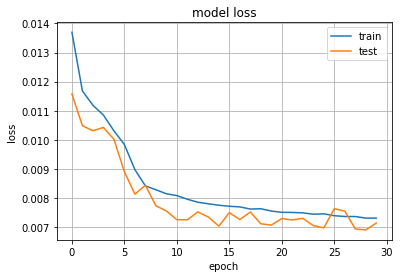

In [41]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

As we can see, losses for testing set are no longer decreasing. It means that our model is close to saturation and further learning can make model overfitted.

### Results - predicted electricity usage for last week of measures from LSTM model

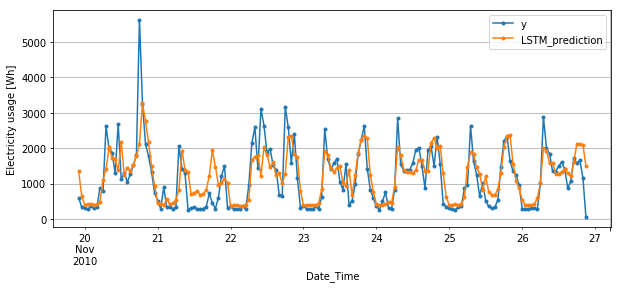

In [42]:
prediction = model.predict(test_x).reshape(test_x.shape[0])

results = pd.DataFrame({'y': test_y, 'LSTM_prediction': prediction})
results *= n_deno.y
results += n_mean.y
results.index = data.index[-split:]

results.plot(figsize=(10,4), marker='.')
plt.ylabel('Electricity usage [Wh]')
plt.show()

Prediction seems to be highly accurate, mimics quantitatively measures. The only inconsistency is that model predictions do not meet peaks heights and bottoms.

### Assessment of LSTM model prediction quality

In [43]:
check_quality(results.y, results.LSTM_prediction)

,Measure,LSTM_prediction
0,Mean absolute error,373.86
1,Root mean squared error,566.62
2,Relative absolute error,54.14%
3,Root relative squared error,44.10%
4,Correlation,0.752


## Future improvements

Results from ML model are satisfactory and the best from all presented models. To improve the model we could include as an input information about public holidays or the weather – which both affect the amount of time spent at home and the consumption of electricity.

## Summary

The analysis concerns an individual household electricity power consumption data set. In the first step, data has been analyzed from statistical point of view. Basics statistics and histograms of attributes were presented. Also correlations between attributes were determined and more precisely investigated relation between voltage and intensity.
<br>
<br>
Then in search of seasonality of active power, the data was grouped and averaged into 3 sets – monthly, daily and hourly. Histograms were presented, where significant changes could be observed. Focusing on data from different rooms, some household members habits were deduced.
<br>
<br>
Next prediction of electricity demands has been proposed, as an area of interest for electricity market. For that, 4 models were tested. First was simply prediction base on changes in consumption for different months/days/hours. Then two regression models were used – AR and SARIMA.
<br>
<br>
At the end machine learning model using LSTM neural network was presented. Details of network design and model prediction were presented in section 'Machine-Learning method – LSTM neural network'. Ideas of improving it are included in section ‘Future improvements’.